# C7: CASE STUDY: BREAST CANCER CLASSIFICATION

### Import and load dataset

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # 0 = malignant, 1 = benign

print(df.head())
print(df['target'].value_counts())


   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

### EDA

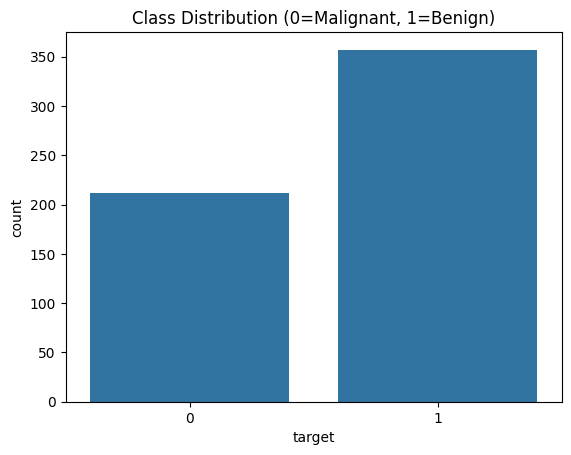

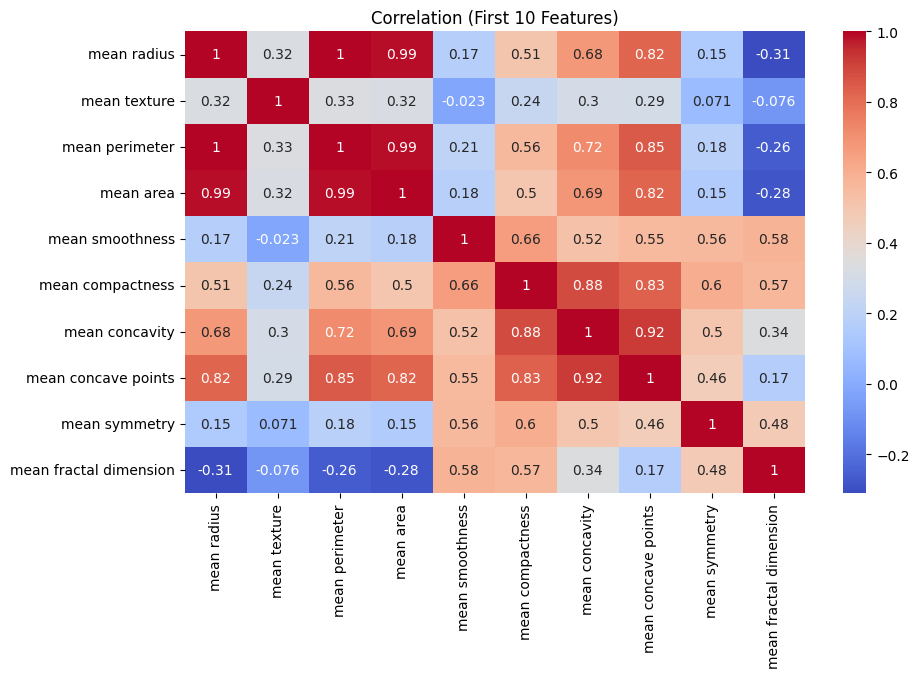

In [13]:
# Check distribution
sns.countplot(x='target', data=df)
plt.title("Class Distribution (0=Malignant, 1=Benign)")
plt.show()

# Correlation heatmap (first 10 features for visibility)
plt.figure(figsize=(10,6))
sns.heatmap(df.iloc[:,:10].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation (First 10 Features)")
plt.show()


### Train test split and scaling

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Import models

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score

### Train models

In [20]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = []
y_probs = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # scaled for consistency
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]  # probability for ROC
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results.append([name, acc, auc])
    
    print(f"\n{name}:\n", classification_report(y_test, y_pred, zero_division=0))
    y_probs[name] = y_prob



Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        64
           1       0.99      0.99      0.99       107

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171


Naive Bayes:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91        64
           1       0.94      0.96      0.95       107

    accuracy                           0.94       171
   macro avg       0.94      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171


KNN:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        64
           1       0.94      1.00      0.97       107

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.96      

### Voting & Stacking ensembles

In [17]:
# Voting Classifier (soft voting)
voting = VotingClassifier(
    estimators=[("lr", LogisticRegression(max_iter=1000, random_state=42)),
                ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
                ("xgb", XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42))],
    voting='soft'
)
voting.fit(X_train_scaled, y_train)
y_probs["Voting"] = voting.predict_proba(X_test_scaled)[:,1]
results.append(["Voting", accuracy_score(y_test, voting.predict(X_test_scaled)), 
                roc_auc_score(y_test, y_probs["Voting"])])

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[("lr", LogisticRegression(max_iter=1000, random_state=42)),
                ("rf", RandomForestClassifier(n_estimators=100, random_state=42)),
                ("gb", GradientBoostingClassifier(n_estimators=100, random_state=42))],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42)
)
stacking.fit(X_train_scaled, y_train)
y_probs["Stacking"] = stacking.predict_proba(X_test_scaled)[:,1]
results.append(["Stacking", accuracy_score(y_test, stacking.predict(X_test_scaled)), 
                roc_auc_score(y_test, y_probs["Stacking"])])


### Comparision table

In [18]:
import pandas as pd

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC-AUC"]).sort_values(by="ROC-AUC", ascending=False)
print("\nModel Performance:\n", results_df)


Model Performance:
                  Model  Accuracy   ROC-AUC
0  Logistic Regression  0.988304  0.998102
9             Stacking  0.964912  0.997518
8               Voting  0.970760  0.997371
7              XGBoost  0.953216  0.993867
4        Random Forest  0.935673  0.991311
5             AdaBoost  0.953216  0.990800
6    Gradient Boosting  0.947368  0.989924
1          Naive Bayes  0.935673  0.989194
2                  KNN  0.959064  0.982696
3        Decision Tree  0.929825  0.944144


### ROC Curves for all models

- **Defintion :** Reciever operating characteristic curve is a graphical plot used to evaluate the performance of a binary classification model.
- **Purpose :** Shows the tradeoff between correctly identifying positves and incorrectly labelling negatives as positives at different thresholds.
- **Axes :** 
    - X-axis : False positive rate = FP / (FP + TN)
    - Y-axis : True positive rate = TP / (TP + FN) => Recall/sensitivity
- **Curve :**
    - A perfect model goes straight up and across.
    - Random guessing is generally diagonal line.
    - The closer the curve is to the top-left corner the better.
- **AUC :**
    - A single number summarizing the ROC curve
        - AUC = 1 => Perfect classifier
        - AUC = 0.5 => Random classifier
        - AUC < 0.5 => Worse than random

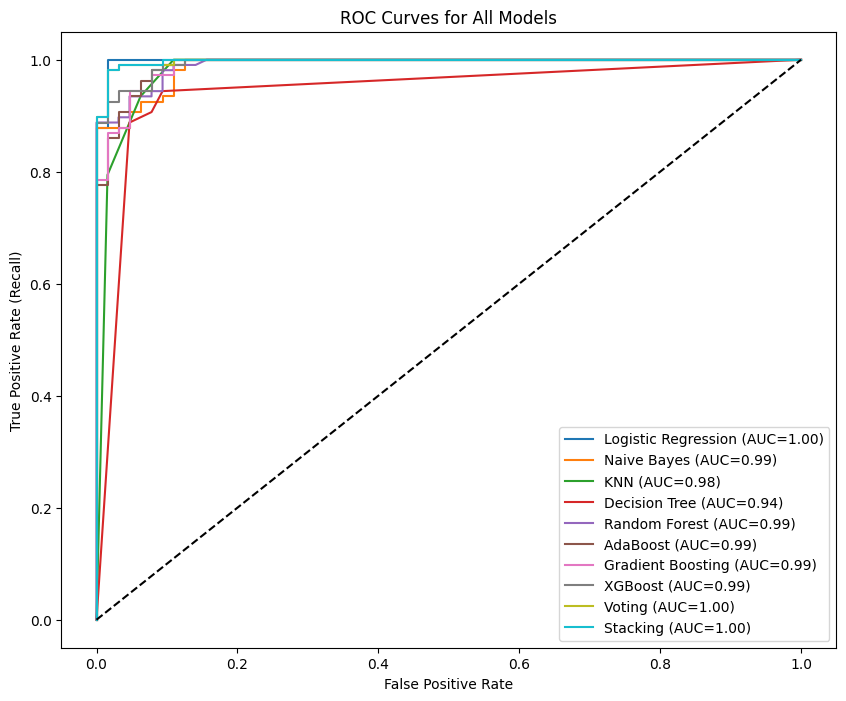

In [19]:
plt.figure(figsize=(10,8))

for name, prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()
